# Data Preparation

Imports, downloading packages for filtering stopwords and normalize words.

In [1]:
# imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import joblib
from datetime import datetime 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# stopwords
nltk.download('stopwords')
nltk.download('punkt')

# word normalizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# constants
conn = sqlite3.connect('StaterData.db')
query = "SELECT * FROM 'mortgage complaints'"
dtypes = {'Date received': str,
          'Product': "category",
          'Sub-product': "category",
          'Issue': "category",
          'Sub-issue':"category",
          'Consumer complaint narrative':str,
          'Company public response':str,
          'Company':"category",
          'State':"category",
          'ZIP code':str,
          'Tags':"category",
          'Consumer consent provided?':str,
          'Submitted via':"category",
          'Date sent to company':str,
          'Company response to consumer':str,
          'Timely response?':str,
          'Consumer disputed?':str,
          'Complaint ID':int
          }

#### Functions for cleaning the text (consumer complaint)

In [4]:
# remove stopwords and return the text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([token for token in nltk.word_tokenize(text) if token.lower() not in stop_words])

def clean_text(text):
    # remove numerical values
    text = re.sub(r'\d+', '', text)

    # remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # remove links and URLs
    text = re.sub(r'http\S+', '', text)

    # remove leading/trailing white space and convert to lowercase
    text = text.strip().lower()

    return text

# lemmitize the word based on its part of speech (POS) tag
def lemmatize_word(word, tag, lemmatizer):
    # map POS tag to WordNet POS tag
    if tag.startswith('J'):
        # adjective
        wn_tag = 'a'
    elif tag.startswith('V'):
        # verb
        wn_tag = 'v'
    elif tag.startswith('N'):
        # noun
        wn_tag = 'n'
    elif tag.startswith('R'):
        # adverb
        wn_tag = 'r'
    else:
        wn_tag = None

    # lemmatize the word
    if wn_tag:
        lemma = lemmatizer.lemmatize(word, wn_tag)
    else:
        lemma = word

    return lemma

# lemmatize the sentence that is already tokenized
def lemmatize_sentence(lemmatizer, tokens):
    # part-of-speech (POS) tag each word
    pos_tags = nltk.pos_tag(tokens)

    # lemmatize each word based on its POS tag
    lemmas = [lemmatize_word(word, tag, lemmatizer) for word, tag in pos_tags]

    # join the lemmas back into a sentence
    lemmatized_sentence = ' '.join(lemmas)

    return lemmatized_sentence

def remove_non_alphabetica_char_and_x(text):
    # remove non alphabetical characters
    alphabetical_text = [re.sub('[^a-zA-Z]+', '', word) for word in text]

    # remove x from the text with regex
    alphabetical_text = [word for word in alphabetical_text if not re.match('^x+$', word)]
    return ' '.join(alphabetical_text)

def clean_complaint(complaint):
        lemmatizer = WordNetLemmatizer()
        cleaned_complaint = remove_stopwords(complaint)
        cleaned_complaint = clean_text(cleaned_complaint)
        # tokenize the sentence into words
        tokens = nltk.word_tokenize(cleaned_complaint)
        cleaned_complaint = lemmatize_sentence(lemmatizer, tokens)
        tokenized_complaint = word_tokenize(cleaned_complaint)
        cleaned_complaint = remove_non_alphabetica_char_and_x(tokenized_complaint)
        return cleaned_complaint

#### Read data in sqlitedb
The text 'Consumer complaint narrative' must be cleaned before modelling

In [5]:
# # load data and clean complaint narrative
# print("load data")
# data = pd.read_sql_query(query, conn, dtype=dtypes)
# df = data[['Consumer complaint narrative', 'Issue']].copy()

# print("clean text")
# df['Clean consumer complaint'] = df['Consumer complaint narrative'].copy()
# df['Clean consumer complaint'] = df['Clean consumer complaint'].apply(lambda x: clean_complaint(x))

#### Read csv data
There is a column named 'Clean consumer complaint'. The text 'Consumer complaint narrative' is already cleaned

In [5]:
data = pd.read_csv('cleanedComplaints.csv', dtype=dtypes)
data['Clean consumer complaint'].astype("string")
df = data[['Clean consumer complaint', 'Issue']].copy()
print("data loaded")

data loaded


# Modelling

In [6]:
# get the independent and dependent variables as x and y
x = df['Clean consumer complaint']
y = df['Issue']
# get all categories of y for the results
cat_issue = y.cat.categories

print("splitting data into train and test sets")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

splitting data into train and test sets


In [7]:
print("vectorize text with TF-IDF")
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]+\b')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

vectorize text with TF-IDF


saga and sag are solvers to use for large datasets. Both supports multinomial logistic regressions. In this case, the sag will be used as it is better in performance. However, saga is a variant of sag and supports more penalties than sag.
more information: https://scikit-learn.org/stable/modules/linear_model.html#solvers

In [8]:
# multinomial logistic regression
print("creating model")
logregression = LogisticRegression(n_jobs=4, solver='saga', multi_class='multinomial', max_iter=1000, random_state=2)

creating model


In [9]:
print("fitting model")
logregression.fit(X_train_tfidf, y_train)

print("predicting test data")
y_pred = logregression.predict(X_test_tfidf)

fitting model
predicting test data


score:0.5708873252889299
accuracy:0.5708873252889299
f1 score:0.5447837714886236


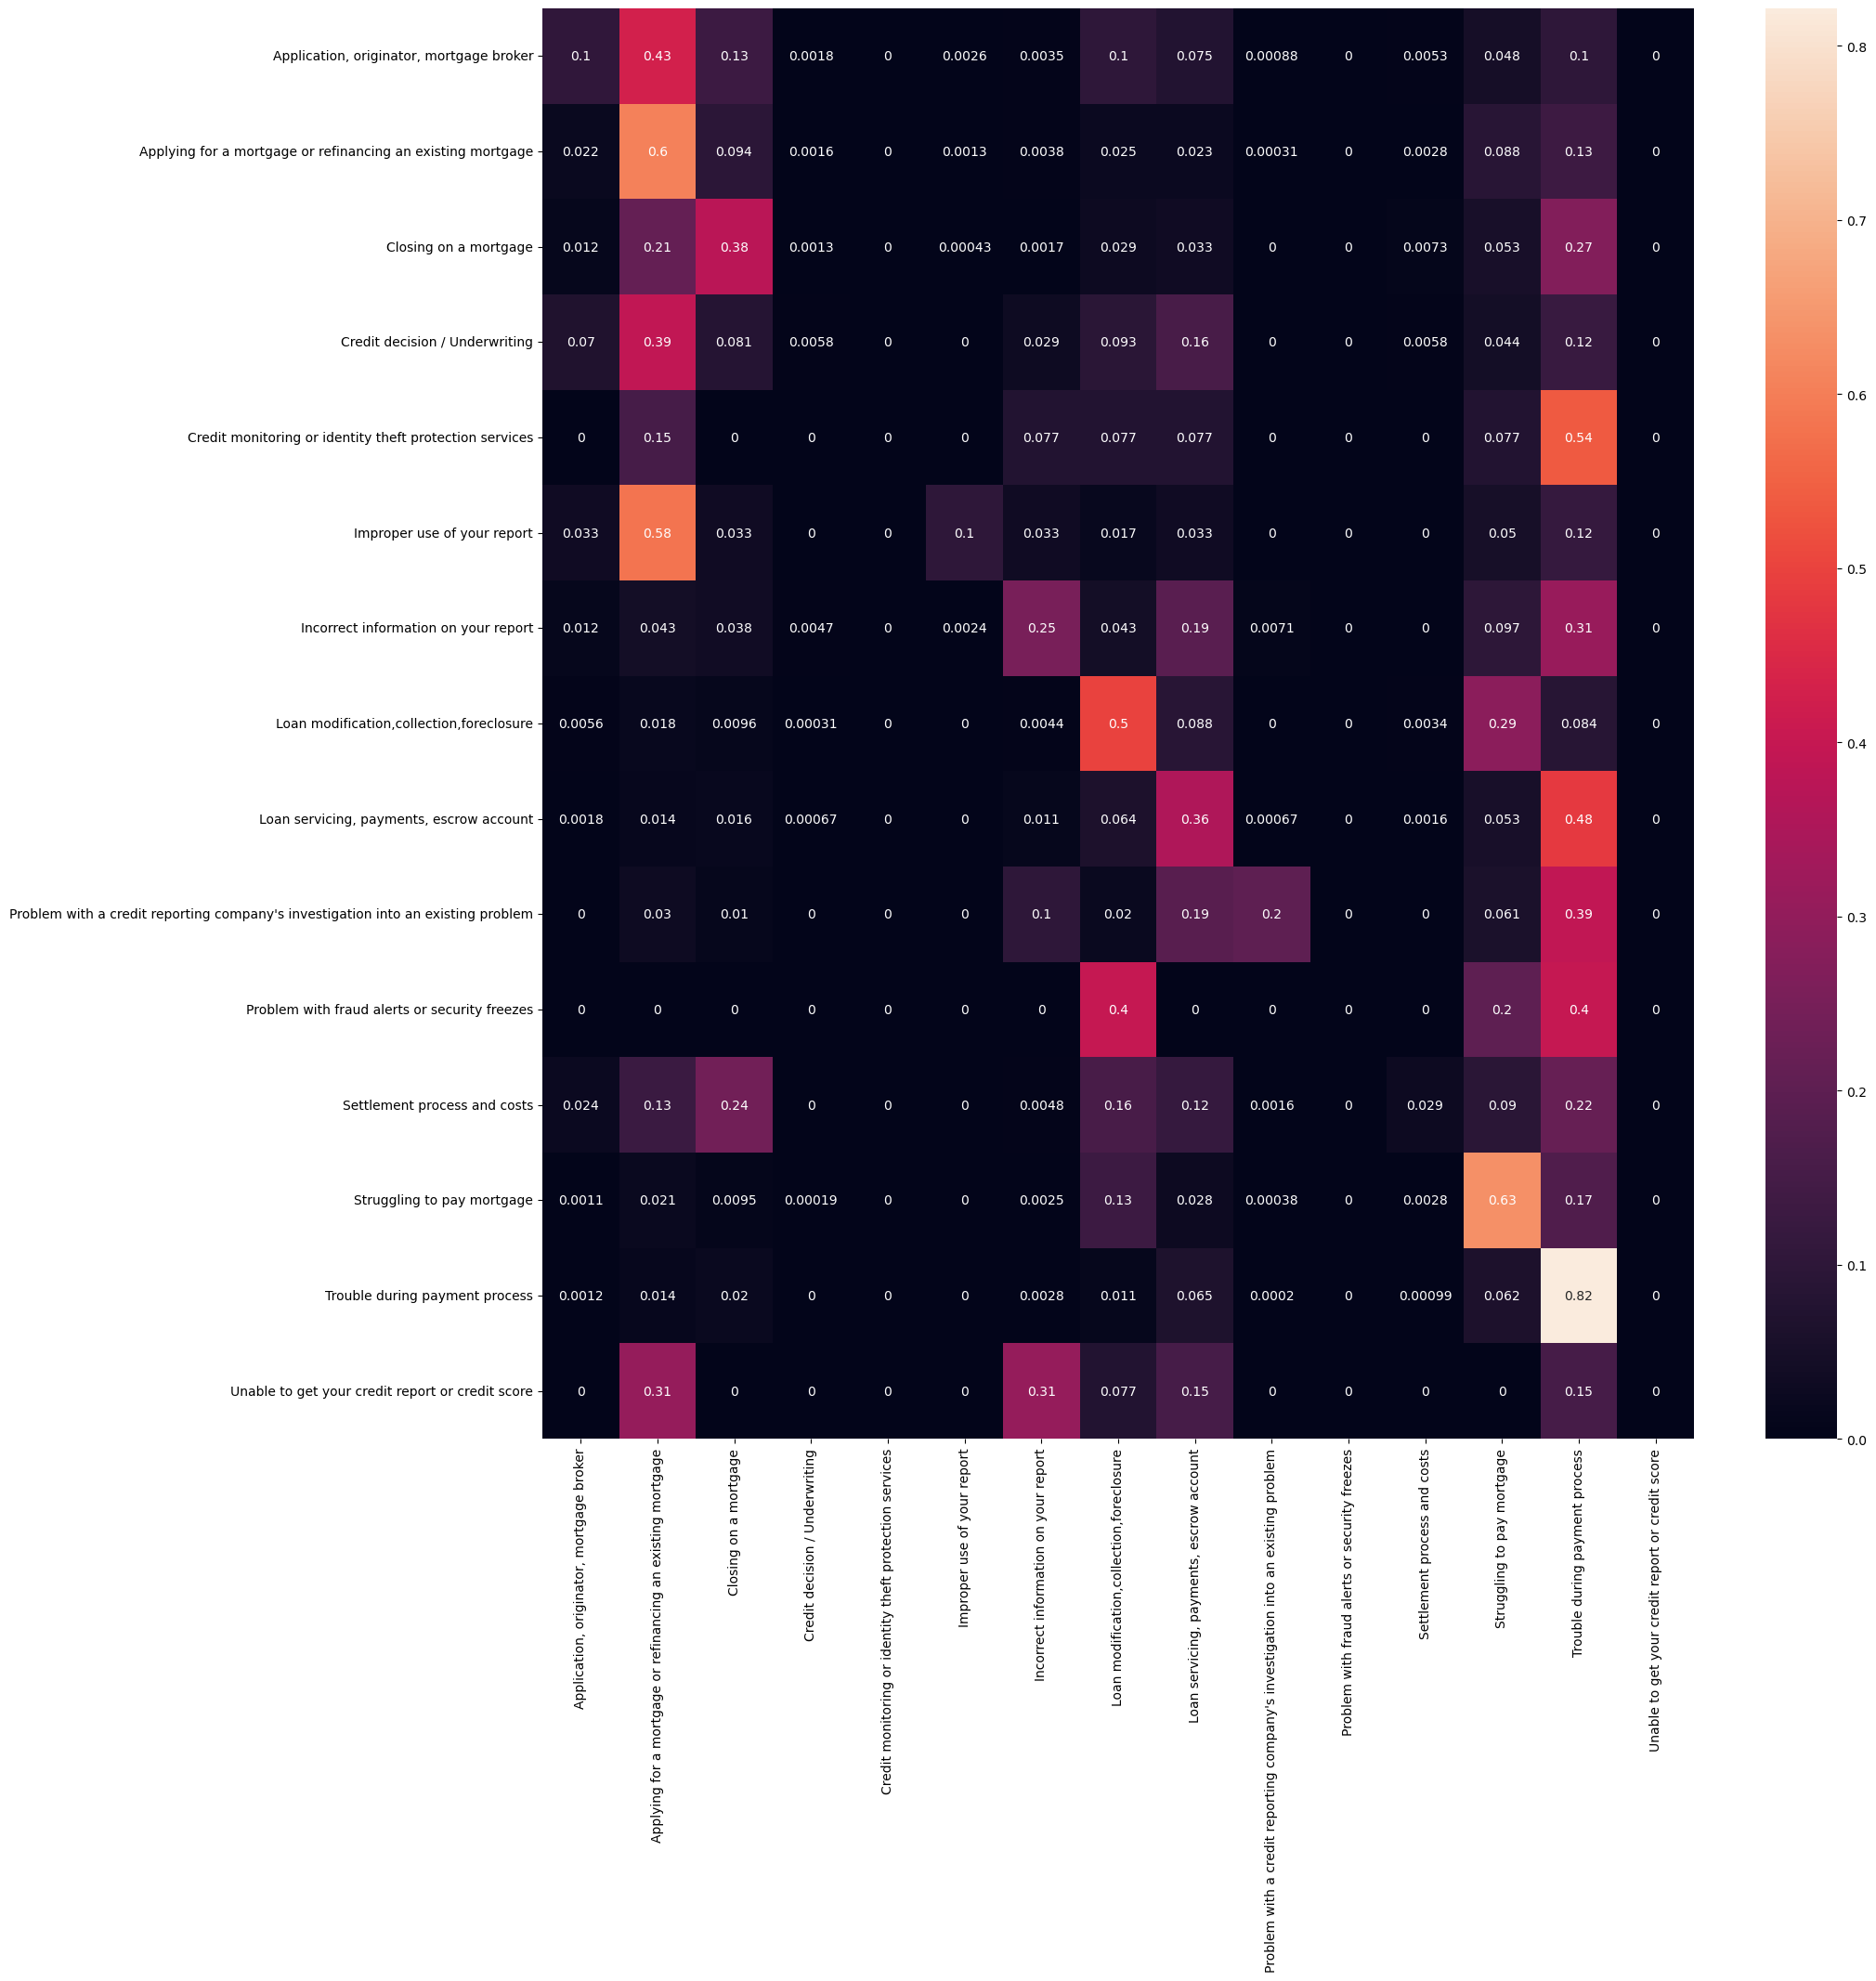

In [10]:
print(f"score:{logregression.score(X_test_tfidf, y_test)}")
print(f"accuracy:{accuracy_score(y_test, y_pred)}")
print(f"f1 score:{f1_score(y_test, y_pred, average='weighted')}")

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=cat_issue, index=cat_issue)
cm = (cm.transpose()/cm.sum(axis=1)).transpose()

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True)
plt.show()

It is seen at the confusion matrix that 'Trouble during payment process', 'Applying for a mortgage or refinancing an existing mortgage', and 'Loan modification,collection,foreclosure' 

In [11]:
print(classification_report(y_test, y_pred, target_names=cat_issue))

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.39      0.10      0.17      1134
                     Applying for a mortgage or refinancing an existing mortgage       0.54      0.60      0.57      3181
                                                           Closing on a mortgage       0.47      0.38      0.42      2329
                                                  Credit decision / Underwriting       0.11      0.01      0.01       344
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        13
                                                     Improper use of your report       0.40      0.10      0.16        60
                                            Incorrect information on your report       0.39      0.25      0.31       422
                       

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# save model with joblib
print("saving model")
date = datetime.today().strftime('%Y-%m-%d')

joblib.dump(logregression, f"logregressionModel{date}.joblib")
joblib.dump(vectorizer, f"vectorizer{date}.joblib")

saving model


['vectorizer2023-05-30.joblib']

## Test model with custom complaint

In [13]:
print("testing model with custom text")
new_complaint = "My mortgage was sold to Roundpoint company in XX/XX/2023. I got a letter in XXXX from my prior lender, XXXX XXXX stating this was to occur and the next payment to be made would go to Roundpoint. But this is false. The information in the letter is not true. I think it is a mistake of yours"
new_complaint_vectorized = vectorizer.transform([new_complaint])
issue_pred = logregression.predict(new_complaint_vectorized)
print('Predicted issue:', issue_pred[0])

testing model with custom text
Predicted issue: Loan servicing, payments, escrow account


## GridSearch
Find the best parameters for this model

In [ ]:
print("creating gridsearch")
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['sag', 'saga'],
    'max_iter': [100, 1000, 2500, 5000],
    'penalty': ['l1', 'l2', 'elasticnet', None]
}
X_train_tfidf_set = X_train_tfidf[0:10001]
y_train_set = y_train[0:10001]
model = LogisticRegression(multi_class='multinomial', n_jobs=4, random_state=2)
grid = GridSearchCV(model, param_grid, verbose=3)
grid.fit(X_train_tfidf_set, y_train_set)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

creating gridsearch
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END C=0.001, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s


C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.327 total time=   3.7s
[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.328 total time=   2.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.328 total time=   1.8s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.328 total time=   1.3s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.328 total time=   0.5s
[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=sag;, score=0.327 total time=   5.5s
[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=sag;, score=0.328 total time=   5.5s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=sag;, score=0.328 total time=   6.3s
[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=sag;, score=0.328 total time=   6.5s
[CV 5/5] END C=0.001, max_iter=100, penalty=l2, solver=sag;, score=0.328 total time=   5.5s
[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=saga;, score=0.327 t

[CV 3/5] END C=0.001, max_iter=2500, penalty=l2, solver=sag;, score=0.328 total time=   5.9s
[CV 4/5] END C=0.001, max_iter=2500, penalty=l2, solver=sag;, score=0.328 total time=   5.7s
[CV 5/5] END C=0.001, max_iter=2500, penalty=l2, solver=sag;, score=0.328 total time=   5.3s
[CV 1/5] END C=0.001, max_iter=2500, penalty=l2, solver=saga;, score=0.327 total time=   3.3s
[CV 2/5] END C=0.001, max_iter=2500, penalty=l2, solver=saga;, score=0.328 total time=   3.7s
[CV 3/5] END C=0.001, max_iter=2500, penalty=l2, solver=saga;, score=0.328 total time=   3.6s
[CV 4/5] END C=0.001, max_iter=2500, penalty=l2, solver=saga;, score=0.328 total time=   3.5s
[CV 5/5] END C=0.001, max_iter=2500, penalty=l2, solver=saga;, score=0.328 total time=   3.3s
[CV 1/5] END C=0.001, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=2500, penalty=elasticn

[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=saga;, score=0.330 total time=   1.9s
[CV 1/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=1

[CV 1/5] END C=0.01, max_iter=5000, penalty=l1, solver=saga;, score=0.327 total time=   1.0s
[CV 2/5] END C=0.01, max_iter=5000, penalty=l1, solver=saga;, score=0.328 total time=   1.0s
[CV 3/5] END C=0.01, max_iter=5000, penalty=l1, solver=saga;, score=0.328 total time=   0.9s
[CV 4/5] END C=0.01, max_iter=5000, penalty=l1, solver=saga;, score=0.328 total time=   0.9s
[CV 5/5] END C=0.01, max_iter=5000, penalty=l1, solver=saga;, score=0.328 total time=   0.9s
[CV 1/5] END C=0.01, max_iter=5000, penalty=l2, solver=sag;, score=0.328 total time=   1.4s
[CV 2/5] END C=0.01, max_iter=5000, penalty=l2, solver=sag;, score=0.328 total time=   1.4s
[CV 3/5] END C=0.01, max_iter=5000, penalty=l2, solver=sag;, score=0.329 total time=   1.4s
[CV 4/5] END C=0.01, max_iter=5000, penalty=l2, solver=sag;, score=0.329 total time=   1.4s
[CV 5/5] END C=0.01, max_iter=5000, penalty=l2, solver=sag;, score=0.330 total time=   1.4s
[CV 1/5] END C=0.01, max_iter=5000, penalty=l2, solver=saga;, score=0.328 t

[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=sag;, score=0.471 total time=   1.5s
[CV 1/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.475 total time=   1.6s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.468 total time=   1.5s
[CV 3/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.463 total time=   1.6s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.469 total time=   1.7s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.471 total time=   1.6s
[CV 1/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver

[CV 1/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.547 total time=  14.3s
[CV 2/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.534 total time=  14.4s
[CV 3/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.535 total time=  14.2s
[CV 4/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.522 total time=  13.0s
[CV 5/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.527 total time=  12.8s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.545 total time=   3.5s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.534 total time=   3.1s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.538 total time=   3.3s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.538 total time=   3.8s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.526 total time=   4.1s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.545 total time=   7.3s
[CV 2/5] END C=1, max_iter

[CV 2/5] END C=1, max_iter=2500, penalty=l2, solver=saga;, score=0.534 total time=  11.4s
[CV 3/5] END C=1, max_iter=2500, penalty=l2, solver=saga;, score=0.538 total time=  10.5s
[CV 4/5] END C=1, max_iter=2500, penalty=l2, solver=saga;, score=0.538 total time=  10.2s
[CV 5/5] END C=1, max_iter=2500, penalty=l2, solver=saga;, score=0.526 total time=  10.2s
[CV 1/5] END C=1, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=2500, penalty=elasticnet, solver=saga;, sc

[CV 1/5] END C=10, max_iter=1000, penalty=l1, solver=saga;, score=0.466 total time= 5.3min
[CV 2/5] END C=10, max_iter=1000, penalty=l1, solver=saga;, score=0.484 total time= 5.7min
